# Tarea 2
Autores:
- Hernán Francisco Díaz Farías
- María Angélica Parra Mendoza
- Loreto Constanza Zavala Gaete


Utilizaremos los datos que nos ha entregado una vidriería, la cual necesita que en base a la composición (química) de los vidros, determinemos cual de ellos podría venir defectuoso de fábrica. Para esto contamos con registro de 214 vidrios, para los cuales cada uno de ellos se nos entrega mediciones de cantidades de Sodio, Magnesio, Aluminio, Silicio, Potacio, Calcio, Bario y Hierro, además de un valor de tipo de vidrio.

## 1.Hacer una exploración de los datos y decidir qué modelo va a utilizar. Fundamentar su elección.
### 1.1 Cargar los datos

In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.svm import OneClassSVM
from pyod.models.dif import DIF
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import math
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
import diptest
RANDOM_STATE= 2024

In [2]:
df = (
    pd.read_excel('../data/Clase 2 - Glass.xlsx')
)
df.head()

,Unnamed: 0,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass,outlier
0,0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,0
2,2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,0
3,3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,0
4,4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,0


Se observa que el dataset trae una columna con el índice de los registros. Se elimina ya que no aporta información útil.

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)

### 1.2 Revisión de nulos

In [4]:
df.isnull().sum()

Na               0
Mg               0
Al               0
Si               0
K                0
Ca               0
Ba               0
Fe               0
Type_of_glass    0
outlier          0
dtype: int64

No se observan registros con valores nulos.

### 1.3 Visualización de histogramas

De acuerdo a la descripción de las ventajas del modelo [**Isolation Forest**](https://cran.r-project.org/web/packages/isotree/vignettes/An_Introduction_to_Isolation_Forests.html), se menciona que:
- Es robusto a la presencia de valores atípicos en los datos de entrenamiento.
- Es robusto a distribuciones multimodal.
- Insensible a la escala de los datos.
- Veloz para entrenar y predecir.
- No varía a la metrica de distancia a utilizar.

Para escoger el modelo, se realizará un análisis de los histogramas de las variables para determinar si son unimodales o multimodales. Si las variables son multimodales, se utilizará el modelo **Isolation Forest**.

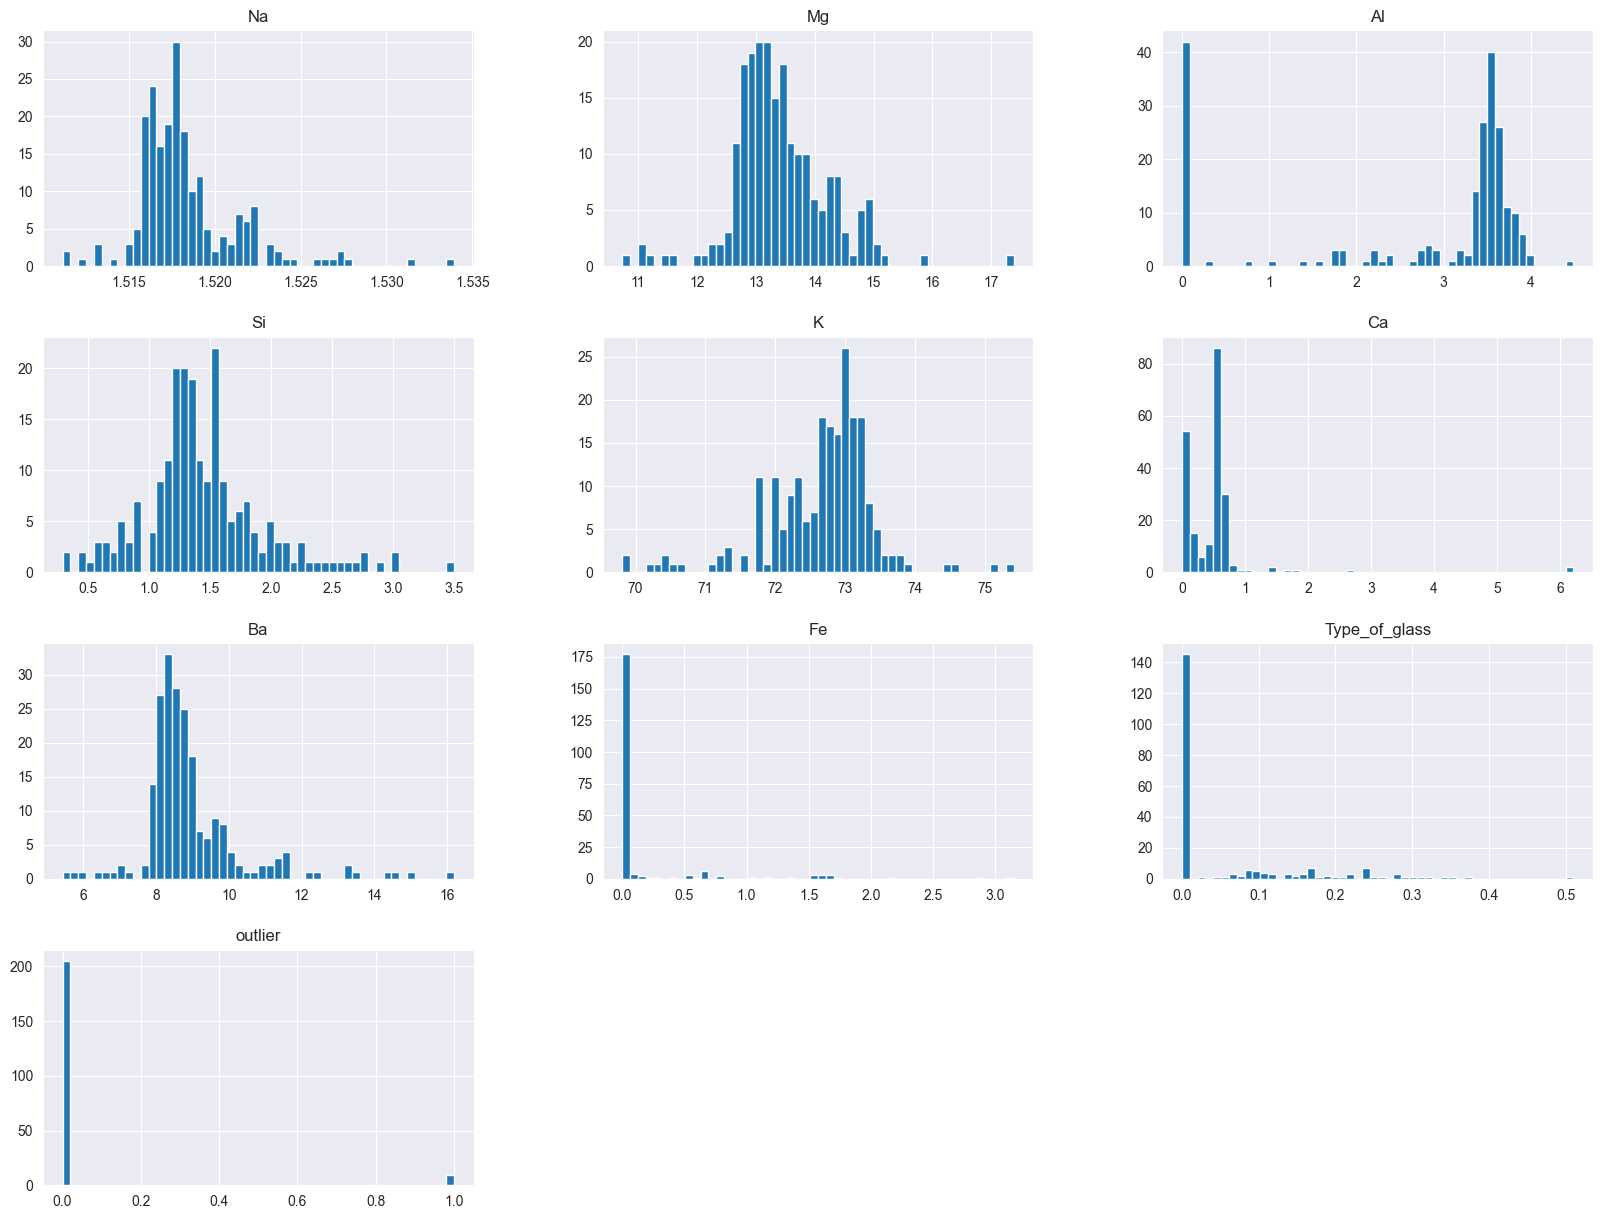

In [5]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

### 1.4 Scatter plot

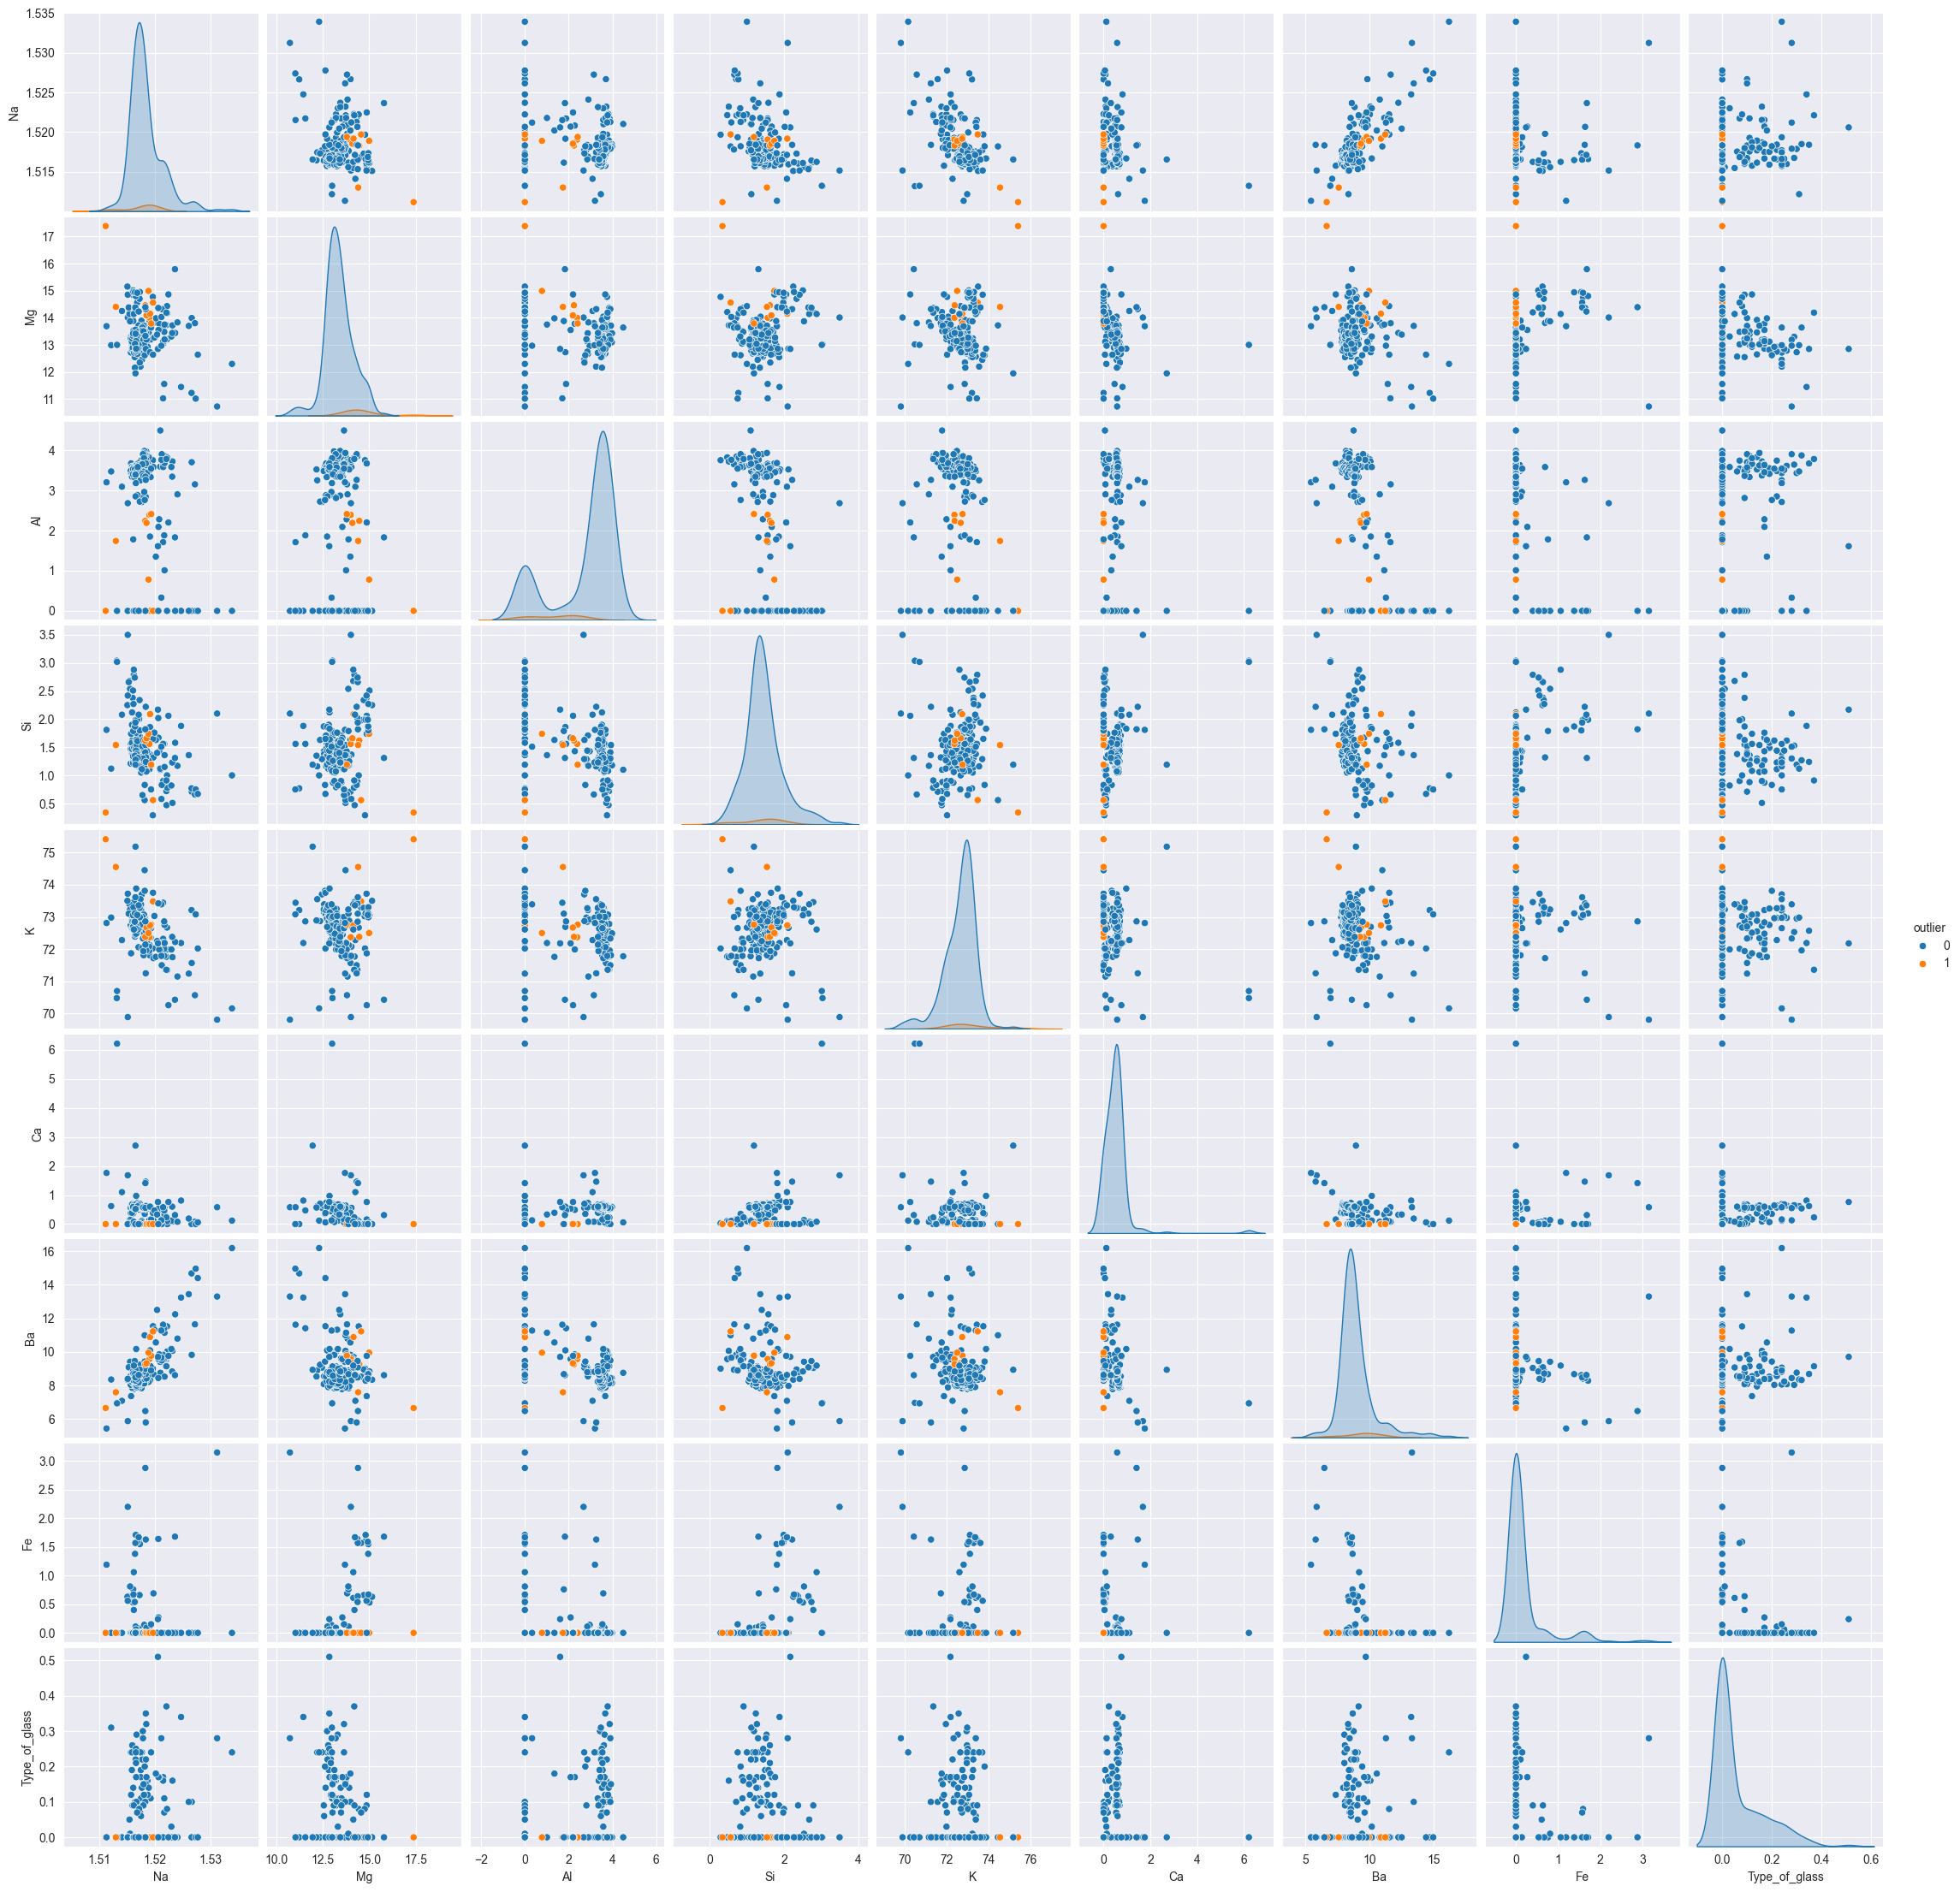

In [6]:
X = df.drop(columns=['outlier'])
y = df['outlier']
sns.pairplot(df, hue='outlier')

De acuerdo al histograma y al pairplot, se observa cierta multimodalidad entre las variables, por lo que se ejecutara el test de Hartigan de unimodalidad.

### 1.5 Test de multimodalidad

In [7]:
for col in df.columns:
    # test dip
    dip, pval = diptest.diptest(df[col])
    if pval < 0.05:
        print(f'La variable {col} es probablemente multimodal: {dip}, {pval}')
    else:
        print(f'La variable {col} es probablemente unimodal: {dip}, {pval}')

La variable Na es probablemente unimodal: 0.027824978759555138, 0.29678227340828256
La variable Mg es probablemente unimodal: 0.02397641299510457, 0.5598736607065488
La variable Al es probablemente multimodal: 0.09813084112149532, 0.0
La variable Si es probablemente unimodal: 0.02266355140186915, 0.6621823323183281
La variable K es probablemente unimodal: 0.019910605444939947, 0.8545579937565113
La variable Ca es probablemente multimodal: 0.07971412864211103, 0.0
La variable Ba es probablemente unimodal: 0.020478284771852703, 0.8206700523552444
La variable Fe es probablemente unimodal: 0.017964693665628247, 0.9483906034584101
La variable Type_of_glass es probablemente unimodal: 0.031061022539857062, 0.15922944239922954
La variable outlier es probablemente unimodal: 0.02102803738317757, 0.7850035090854165


De acuerdo a los histogramas y el test de multimodalidad, se observa que existen variables que son unimodales y otras que son multimodales. Por lo tanto, un modelo candidato es **Isolation Forest** para detectar los vidrios defectuosos de fábrica.

### 1.6 Valores de la variable dependiente

In [8]:
y.value_counts()

outlier
0    205
1      9
Name: count, dtype: int64

La cantidad de outliers es ínfima en comparación a los inliers, este desbalance puede afectar el desempeño de los modelos.

## 2. En base a su elección anterior, procese sus datos para dejarlos como input para el modelo.
### 2.1 Función de scores
Para encontrar los vidrios defectuosos de fábrica, se utilizará como factor determinante el f1-score, ya que se solicita expresamente detectar la mayor cantidad de outliers, al mismo tiempo que minimizar la cantidad de valores mal predichos.

In [12]:
def mis_scores(resultados, outliers):
    TP = ((outliers == 1) & (resultados == -1)).sum()
    TN = ((outliers == 0) & (resultados == 1)).sum()
    FP = ((outliers == 0) & (resultados == -1)).sum()
    FN = ((outliers == 1) & (resultados == 1)).sum()
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def mostrar_resultados(mis_scores):
    print(f'TP: {mis_scores["TP"]}, TN: {mis_scores["TN"]}, FP: {mis_scores["FP"]}, FN: {mis_scores["FN"]}, Accuracy: {mis_scores["accuracy"]}, Precision: {mis_scores["precision"]}, Recall: {mis_scores["recall"]}, F1: {mis_scores["f1"]}')

### 2.2 Estandarización
Los modelos en general se benefician al escalar los datos, ya sea en velocidad de ejecución y/o en mayor certeza. Como prueba se estandarizarán los datos con StandarScaler.
Cabe destacar que los árboles no mejorar su eficacia con el escalamiento, pero si pueden mejorar su eficiencia, es decir, entrenarse más rápido.

In [41]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

### 2.3 Isolation Forest

In [42]:
iso_forest = IsolationForest(n_jobs=-1, random_state=RANDOM_STATE)
predicciones_iso = iso_forest.fit_predict(X_scaled)
score = mis_scores(predicciones_iso, y)
mostrar_resultados(score)

TP: 1, TN: 185, FP: 20, FN: 8, Accuracy: 0.8691588785046729, Precision: 0.047619047619047616, Recall: 0.1111111111111111, F1: 0.06666666666666667


Al ejecutar el modelo en modo "vanilla", es decir sin hacer fin tuning de hiperparametros, se observa un muy buen accuracy de 86.91%, sin embargo, esto se debe al desbalanceo mencionado ateriormente.

El modelo tiene un desempeño muy pobre con el F1 score, tan solo un 6.66%, que es la métrica que nos interesa.

### 2.4 Fine Tuning mediante pipelines

Para encontrar los mejores hiperparámetros, se utilizarán pipelines. Adicionalmente, se evaluará el desempeño del modelo modificado el threshold o umbral de la predicción.

In [39]:
pipeline = Pipeline([
    ('model', IsolationForest(random_state=RANDOM_STATE, n_jobs=-1))
])

# Definir los hiperparámetros del modelo **Isolation Forest**:
params= {
    'model__n_estimators': [1, 100, 200, 300], # número de árboles
    'model__max_samples': [50, 100, 200, 214, 'auto'], # máximo número de muestras a extraer del dataset
    'model__contamination': [0.03, 0.04, 0.05, 'auto'], # proporción de outliers en el dataset
    'model__bootstrap': [True, False], # Técnica de remuestreo
    'model__max_features': [1, 2, 3, 4 ,5, 6 ,7, 8, 9]
}
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_params = None
best_score = 0
best_threshold = 0

# Combinar el pipeline y los hiperparámetros
for n_estimators in params['model__n_estimators']:
    for max_samples in params['model__max_samples']:
        for contamination in params['model__contamination']:
            for bootstrap in params['model__bootstrap']:
                for features in params['model__max_features']:
                    pipeline.set_params(
                        model__n_estimators=n_estimators,
                        model__max_samples=max_samples,
                        model__contamination=contamination,
                        model__bootstrap=bootstrap,
                        model__max_features=features
                    )
                    pipeline.fit(X)
                    scores = pipeline.decision_function(X)
                    probas = (scores - scores.min()) / (scores.max() - scores.min()) # Forma manual de extraer las probabilidades de un pipeline
                    for umbral in threshold:
                        predicciones = np.array([-1 if x > umbral else 1 for x in probas])
                        resultados = mis_scores(predicciones, y)
                        if resultados['f1'] > best_score:
                            best_score = resultados['f1']
                            best_params = {
                                'model__n_estimators': n_estimators,
                                'model__max_samples': max_samples,
                                'model__contamination': contamination,
                                'model__bootstrap': bootstrap,
                                'model__max_features': features,
                                'threshold': umbral
                            }
                            mejor_resultado = resultados
print(f'Mejores hiperparámetros: {best_params}')
print(f'Mejor score: {best_score}')
mostrar_resultados(mejor_resultado)

Mejores hiperparámetros: {'model__n_estimators': 1, 'model__max_samples': 50, 'model__contamination': 0.03, 'model__bootstrap': True, 'model__max_features': 6, 'threshold': 0.9}
Mejor score: 0.15584415584415584
TP: 6, TN: 143, FP: 62, FN: 3, Accuracy: 0.6962616822429907, Precision: 0.08823529411764706, Recall: 0.6666666666666666, F1: 0.15584415584415584


Aplicamos los mejores hiperparametros en el modelo

In [40]:
iso_best = IsolationForest(random_state=RANDOM_STATE,
                           n_jobs=-1,
                           max_features=best_params['model__max_features'],
                           bootstrap=best_params['model__bootstrap'],
                           contamination=best_params['model__contamination'],
                           n_estimators=best_params['model__n_estimators'],
                           max_samples=best_params['model__max_samples'])
mejor_prediccion = iso_best.fit_predict(X)
score_best = mis_scores(mejor_prediccion, y)
print('Sin modificar el umbral')
mostrar_resultados(score_best)
print('modificando el umbral')
decision_scores = iso_best.decision_function(X)
probabilidades = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
score_best_umbral = np.array([-1 if x > best_params['threshold'] else 1 for x in probabilidades])
score_best_umbral = mis_scores(score_best_umbral, y)
mostrar_resultados(score_best_umbral)



Sin modificar el umbral
TP: 0, TN: 198, FP: 7, FN: 9, Accuracy: 0.9252336448598131, Precision: 0.0, Recall: 0.0, F1: 0
modificando el umbral
TP: 6, TN: 143, FP: 62, FN: 3, Accuracy: 0.6962616822429907, Precision: 0.08823529411764706, Recall: 0.6666666666666666, F1: 0.15584415584415584


Con este modelo se detectan correctamente 6 vidrios con imperfecciones.
Se detectan erroneamente como defectuosos 62 vidrios.
Se consideran 3 vidrios con imperfecciones como vidrios en buen estado.

Considerando los resultados anteriores, se concluye que para mejorar la utilidad del modelo, se podría considerar una función de costo para poder estimar el impacto de detectar los vidrios con imperfecciones y/ o el costo de detectar como imperfectos 62 vidrios en buen estado.

## 3. Ocupe el modelo escogido y exponga las principales características que tienen los datos encontrados como anómalos.

### 3.1 Features más importantes
Mediante el siguiente código podemos ver las features más importantes del modelo.

In [47]:
# Obtener las características utilizadas por cada árbol
features = iso_best.estimators_features_

# Mapear los índices de las características a los nombres de las columnas
columnas = df.columns
features_nombres = [[columnas[i] for i in tree_features] for tree_features in features]

# Mostrar las características utilizadas por el árbol
print(f'Características utilizadas por el primer árbol: {features_nombres[0]}')


Características utilizadas por el primer árbol: ['Fe', 'Ba', 'Type_of_glass', 'Mg', 'K', 'Na']


Las variables independientes utilizadas por el modelo son:
- Fe
- Ba
- Type_of_glass
- Mg
- K
- Na